In [1]:
import os.path as osp
import argparse

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv,GATConv  # noqa

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import negative_sampling

dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = data.x.to(device)
y = data.y.squeeze().to(device)

#from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from torch_sparse import SparseTensor
row=[]
col =[]
x_new = [j for j in range(len(x))]
x_new = torch.IntTensor(x_new)
x_new = x_new[data.train_mask]
for j, i in enumerate(data.edge_index[0]):
    if i in x_new:
        if data.edge_index[1][j] in x_new:
                row.append(i)
                col.append(data.edge_index[1][j])
row = torch.tensor(row)
row = row.to(device)
col = torch.tensor(col)
col = col.to(device)

adj = SparseTensor(row=row, col=col, sparse_sizes=(140, 140)).to(device)

In [3]:
from torch.utils.data import DataLoader
from sampling import sample
loader = DataLoader(range(adj.sparse_size(0)),collate_fn=sample)

In [4]:
#UNSUPERVISED
num_feat = dataset.num_features
num_class = dataset.num_classes
from model import Net
model = Net(num_features=num_feat,num_classes =num_class,mode='UNSUP',conv='GAT')
model.to(device)

#scheduler = ReduceLROnPlateau(optimizer, 'min') 

from sklearn.model_selection import train_test_split 


In [5]:
losses=[]
train_accs =[]
val_accs =[]
test_accs=[]
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
from train_test import train,test
for epoch in range(1, 20):
    loss = train(model,data,optimizer,loader)
    losses.append(loss)
    train_acc, val_acc, test_acc = test(model,data)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    val_accs.append(val_acc)
    #scheduler.step(loss)
    log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(loss, epoch, train_acc, val_acc, test_acc))


C:\Users\anpolol\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Loss: 1.3855, Epoch: 001, Train: 0.9143, Val: 0.9420, Test: 0.9240
Loss: 1.3852, Epoch: 002, Train: 0.9071, Val: 0.9380, Test: 0.9290
Loss: 1.3846, Epoch: 003, Train: 0.9000, Val: 0.9300, Test: 0.9210
Loss: 1.3840, Epoch: 004, Train: 0.9214, Val: 0.9400, Test: 0.9290
Loss: 1.3832, Epoch: 005, Train: 0.9143, Val: 0.9480, Test: 0.9270
Loss: 1.3826, Epoch: 006, Train: 0.9286, Val: 0.9540, Test: 0.9360
Loss: 1.3815, Epoch: 007, Train: 0.9286, Val: 0.9400, Test: 0.9290
Loss: 1.3806, Epoch: 008, Train: 0.9286, Val: 0.9500, Test: 0.9340
Loss: 1.3791, Epoch: 009, Train: 0.9286, Val: 0.9560, Test: 0.9380
Loss: 1.3775, Epoch: 010, Train: 0.9143, Val: 0.9520, Test: 0.9360
Loss: 1.3763, Epoch: 011, Train: 0.9286, Val: 0.9600, Test: 0.9410
Loss: 1.3752, Epoch: 012, Train: 0.9286, Val: 0.9420, Test: 0.9310
Loss: 1.3725, Epoch: 013, Train: 0.9357, Val: 0.9500, Test: 0.9330
Loss: 1.3708, Epoch: 014, Train: 0.9500, Val: 0.9540, Test: 0.9340
Loss: 1.3689, Epoch: 015, Train: 0.9429, Val: 0.9500, Test: 0.

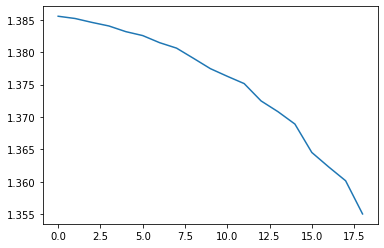

In [8]:
import matplotlib.pyplot as plt
plt.plot(losses)

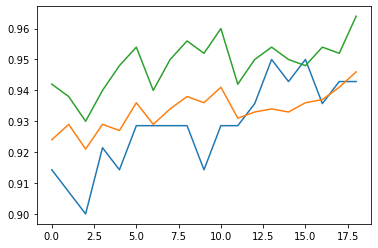

In [9]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.plot(val_accs)